# Predicting Customer Churn with Machine Learning 🏦💰

<br>

**Table of Contents**

- [Introduction](#Introduction)
- [Libraries](#Libraries)
- [Default Parameters](#Default-Parameters)
- [Functions](#Functions)
- [A Quick Look at our Data](#A-Quick-Look-at-our-Data)
- [Creating a Test Set](#Creating-a-Test-Set)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Target Variable: Exited](#Target-Variable:-Exited)
    - [Continuous Variables](#Continuous-Variables)
    - [Categorical Variables](#Categorical-Variables)
- [Data Preprocessing](#Data-Preprocessing)
    - [Feature Selection](#Feature-Selection) <br>
    - [Encoding Categorical Features](#Encoding-Categorical-Features) <br>
    - [Scaling](#Scaling) <br>
    - [Addressing Class Imbalance](#Addressing-Class-Imbalance) 
- [Building Machine Learning Models](#Building-Machine-Learning-Models)
    - [Baseline Models](#Baseline-Models) <br>
    - [Model Tuning](#Model-Tuning) <br>
- [Results](#Results)
- [Evaluating the Test Set](#Evaluating-the-Test-Set)
- [Bibliography](#Bibliography)
- [Conclusions](#Conclusions)


<br>

# Introduction

<br>

# Libraries

In [2]:
# Data Handling and Analysis
import numpy as np
import pandas as pd

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy.stats import chi2_contingency

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

import scikitplot as skplt

<br>

# Default Parameters

In [3]:
pd.set_option('precision', 3)

%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

edgecolor = 'white'
facecolor = '#f0f0f0'

plt.rcParams['axes.edgecolor'] = '0.15'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.facecolor'] = facecolor

font_size = 20
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

random_state = 0

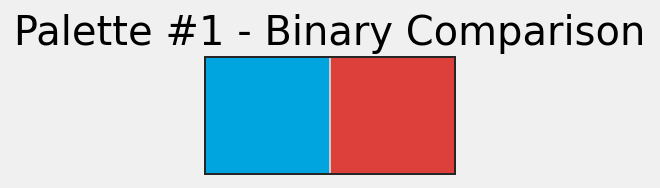

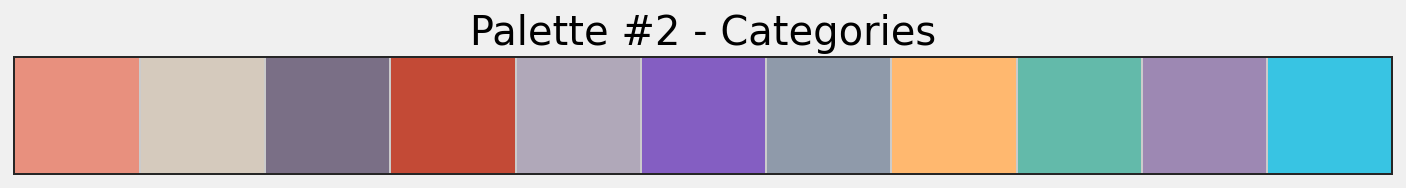

In [4]:
colors = ['#00A5E0', '#DD403A']
colors_cat = [
    '#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2',
    '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3'
]

sns.palplot(colors)
plt.title('Palette #1 - Binary Comparison')
plt.tick_params(axis='x', bottom=False, labelbottom=False)

sns.palplot(colors_cat)
plt.title('Palette #2 - Categories')
plt.tick_params(axis='x', bottom=False, labelbottom=False)

In [5]:
scoring_metric = 'roc_auc'

<br>

# Functions

## `plot_continuous()`

In [6]:
def plot_continuous(df, feature):
    '''Plot a histogram and boxplot for the churned and retained distributions for the specified feature.'''
    df_churned = df[df['Exited'] == 1]
    df_retained = df[df['Exited'] == 0]

    df_func = df.copy()
    df_func['Exited'] = df_func['Exited'].astype('category')

    fig, (ax1, ax2) = plt.subplots(2,
                                   figsize=(9, 7),
                                   sharex=True,
                                   gridspec_kw={'height_ratios': (.7, .3)})

    for df, color, label in zip([df_retained, df_churned],
                                colors,
                                ['Retained', 'Churned']):
        sns.histplot(data=df,
                     x=feature,
                     bins=15,
                     color=color,
                     alpha=0.66,
                     edgecolor=edgecolor,
                     label=label,
                     kde=False,
                     ax=ax1)
    ax1.legend()

    sns.boxplot(x=feature,
                y='Exited',
                data=df_func,
                linewidth=1.5,
                palette=colors,
                ax=ax2)
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Retained', 'Churned'])

    plt.tight_layout()

<br>

## `plot_categorical()`

In [7]:
def plot_categorical(df, feature):
    '''For a categorical feature, plot a seaborn.countplot for the total counts of each category next to a barplot for the churn rate.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    sns.countplot(x=feature,
                  hue='Exited',
                  data=df,
                  palette=colors,
                  ax=ax1)
    
    ax1.set_ylabel('Count')
    ax1.legend(labels=['Retained', 'Churned'])

    sns.barplot(x=feature,
                y='Exited',
                data=df,
                palette=colors_cat, errwidth=2,
                ax=ax2)
    
    ax2.set_ylabel('Churn rate')

    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])

    plt.tight_layout()

<br>

# A Quick Look at our Data

We start by importing the dataset as a Pandas DataFrame. We can also take a look at the top five rows using the `head()` method:

In [8]:
df = pd.read_csv('Data\Dataset.csv')

print('Dataset Imported Successfully!\n')
print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
print('Top five rows:')
df.head()

Dataset Imported Successfully!

It contains 10000 rows and 14 columns.
Top five rows:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Our DataFrame has 14 features/attributes and 10K customers/instances. The last feature, '**Exited**', is the **target variable** and indicates whether the customer has churned (0 = No, 1 = Yes). The meaning of the rest of the features can be easily inferred from their name.

Features 'RowNumber', 'CustomerId', and 'Surname' are specific to each customer and can be dropped:

In [9]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

The `info()` method can give us valuable information such as the number of non-null values and the type of each feature:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Thankfully, there are **no missing values** in our DataFrame. The `describe()` method gives us a statistical summary of the numerical features:

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.529,96.653,350.00,584.00,652.000,718.000,850.00
Age,10000.0,38.922,10.488,18.00,32.00,37.000,44.000,92.00
Tenure,10000.0,5.013,2.892,0.00,3.00,5.000,7.000,10.00
Balance,10000.0,76485.889,62397.405,0.00,0.00,97198.540,127644.240,250898.09
NumOfProducts,10000.0,1.530,0.582,1.00,1.00,1.000,2.000,4.00
HasCrCard,10000.0,0.706,0.456,0.00,0.00,1.000,1.000,1.00
IsActiveMember,10000.0,0.515,0.500,0.00,0.00,1.000,1.000,1.00
EstimatedSalary,10000.0,100090.240,57510.493,11.58,51002.11,100193.915,149388.247,199992.48
Exited,10000.0,0.204,0.403,0.00,0.00,0.000,0.000,1.00


The most important things to note are:

- The age of customers ranges from 18 to 92, with a mean value approximately equal to 40.
- The mean (and median) tenure is 5 years, so the majority of customers is loyal (tenure > 3).
- Approximately 50% of customers are active.

EDA will help us understand our dataset better. However, before we look at the data further, we need to create a **test set**, put it aside, and use it only to evaluate our Machine Learning models. This practice protects our models from **data snooping bias** (you can read more on page 51 of Ref. [[1](#Bibliography)]) and ensures that evaluation will be performed using unseen data. 

<br>

# Creating a Test Set

We will split our dataset into a train and a test set using scikit-learn's `StratifiedShuffleSplit()` function, which implements **stratified sampling**. In this method, the population is divided into homogeneous subgroups called *strata*, and the right number of instances are sampled from each stratum to guaranτee that the test set is representative of the overall population ([[1](#Bibliography)]).

In [12]:
split = StratifiedShuffleSplit(n_splits=1,
                               test_size=0.2,
                               random_state=random_state)

for train_index, test_index in split.split(df, df['Exited']):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]

<br>

---

# Exploratory Data Analysis

## Target Variable: Exited

As we mentioned earlier, the target variable is already encoded and can take two possible values:

- Zero (0) for a customer that has **not** churned, and
- One (1) for a customer that has churned.

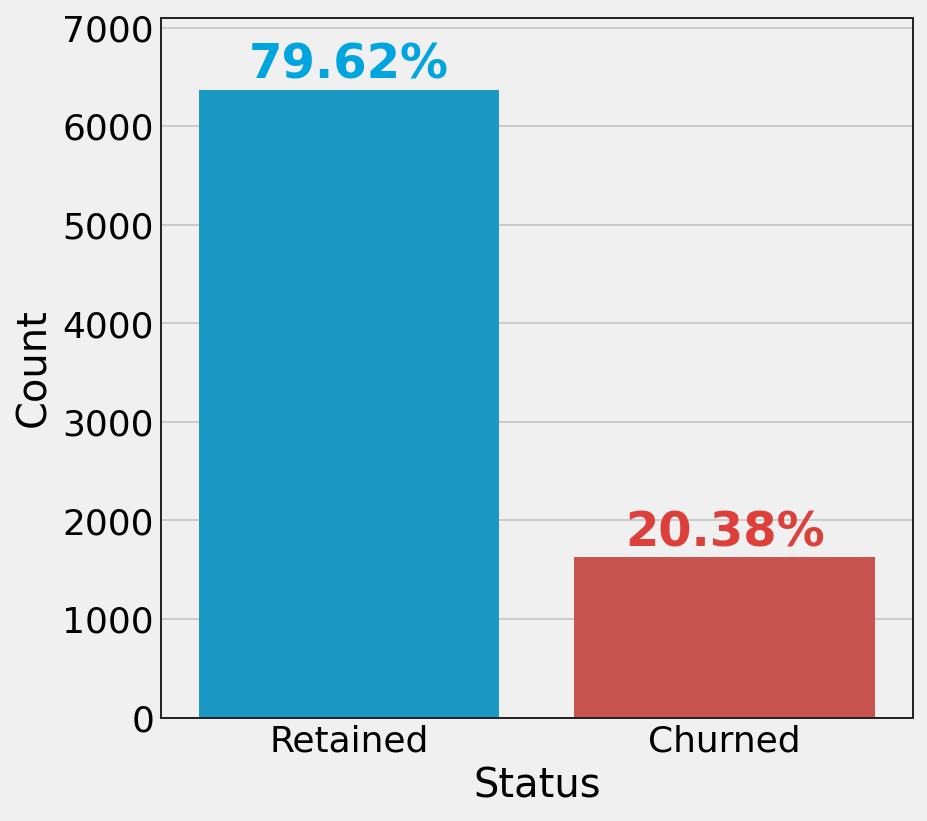

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.countplot(x='Exited', data=train_df, palette=colors, ax=ax)

for index, value in enumerate(train_df['Exited'].value_counts()):
    label = '{}%'.format(round((value / train_df['Exited'].shape[0]) * 100, 2))
    ax.annotate(label,
                xy=(index, value + 250),
                ha='center',
                va='center',
                color=colors[index],
                fontweight='bold',
                size=font_size + 4)

ax.set_xticklabels(['Retained', 'Churned'])
ax.set(xlabel='Status', ylabel='Count')
ax.set_ylim([0, 7100]);

The bank kept 80% of its clientele.

Notice that our dataset is **skewed/imbalanced** since the number of instances in the 'Retained' class outnumbers the number of instances in the 'Churned' class by a factor of 4. Therefore, we need to factor in class imbalance before building any models.

Different visualisation techniques apply to different types of variables, so it is helpful to differentiate between continuous and categorical variables and look at them separately.

In [14]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

print('Continuous: ', ', '.join(continuous))
print('Categorical: ', ', '.join(categorical))

Continuous:  Age, CreditScore, Balance, EstimatedSalary
Categorical:  Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember


<br>

## Continuous Variables

By calling the `hist()` method, we can plot a histogram for each of the four continuous numeric features:

C:\Users\ko40\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


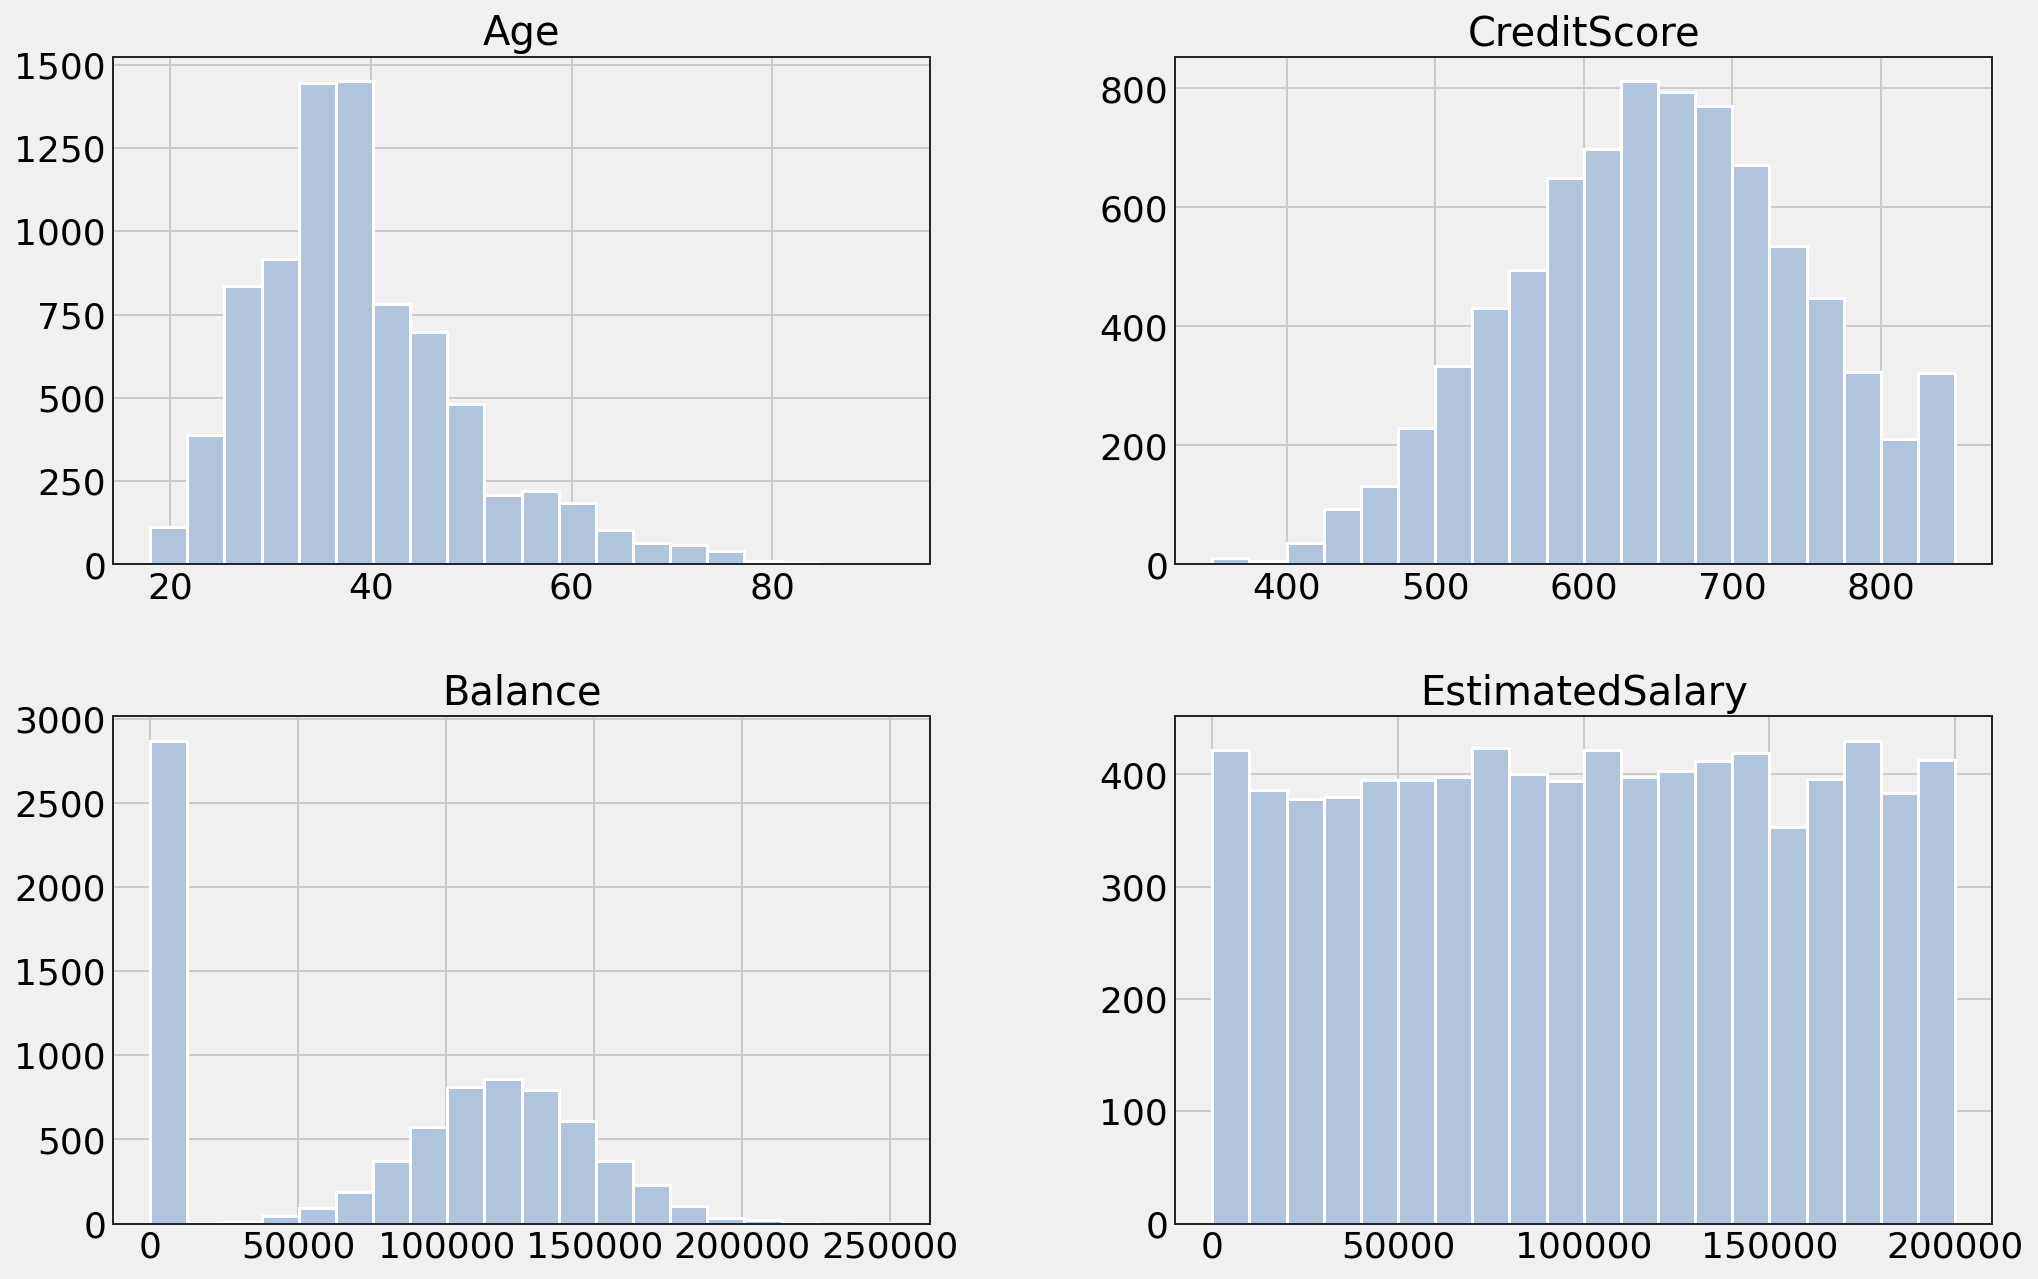

In [15]:
fig, ax = plt.subplots(figsize=(15, 10), facecolor=facecolor)

train_df[continuous].hist(bins=20,
                          layout=(2, 2),
                          color='lightsteelblue',
                          edgecolor=edgecolor,
                          linewidth=1.5,
                          ax=ax);

- 'Age' is slightly tail-heavy, i.e. it extends more further to the right of the median than to the left,
- Most values for 'CreditScore' are above 600,
- If we ignore the first bin, 'Balance' follows a relatively normal distribution, and
- The distribution of 'EstimatedSalary' is more or less uniform and provides little information.

<br>

### Looking for Correlations

We can compute the standard correlation coefficient between every pair of (continuous) features using the pandas' `corr()` method and plot it as a matrix:

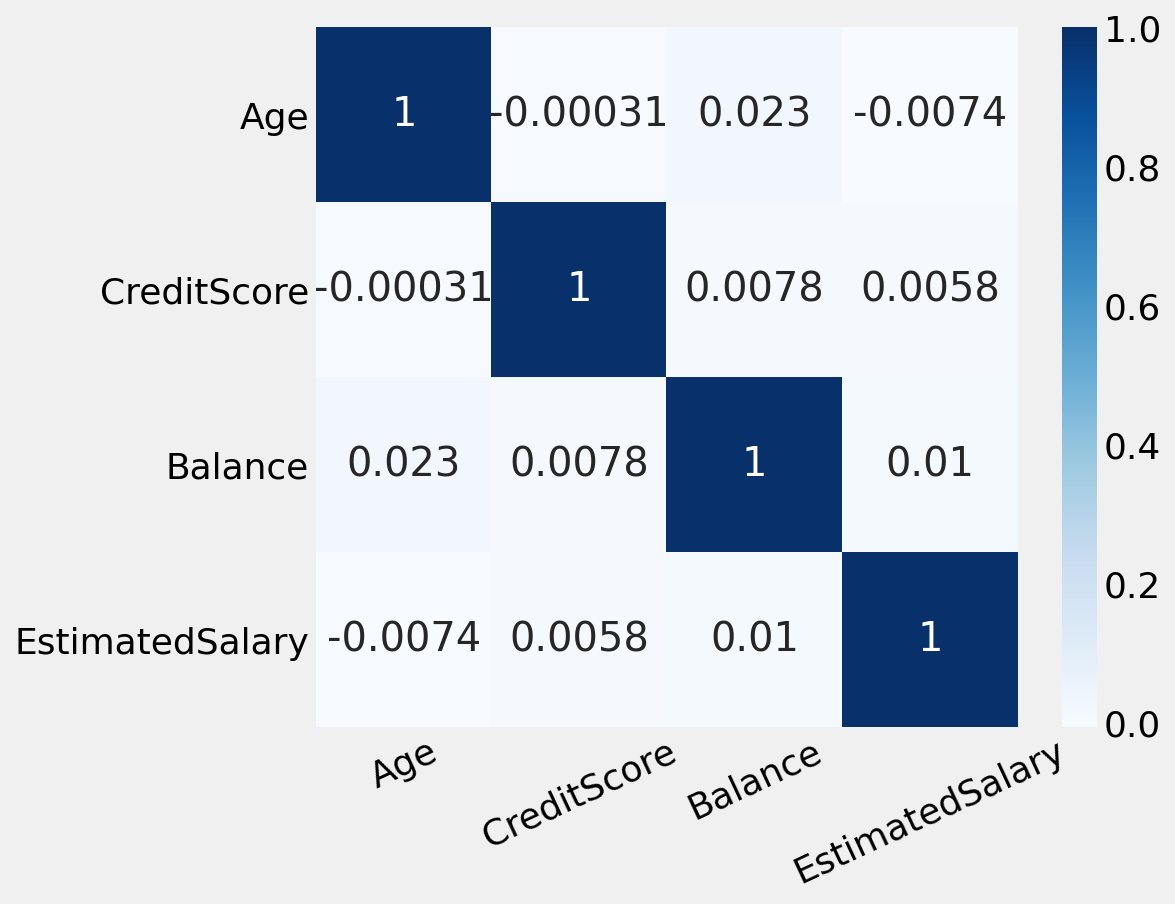

In [16]:
ig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(train_df[continuous].corr(),
            annot=True,
            annot_kws={'fontsize': font_size},
            cmap='Blues',
            ax=ax)

ax.tick_params(axis='x', rotation=25)
ax.tick_params(axis='y', rotation=360);

There is no significant intercorrelation between our features, so we do **not** have to worry about multicollinearity.

Let's look at these features in greater detail.

<br>

### Age

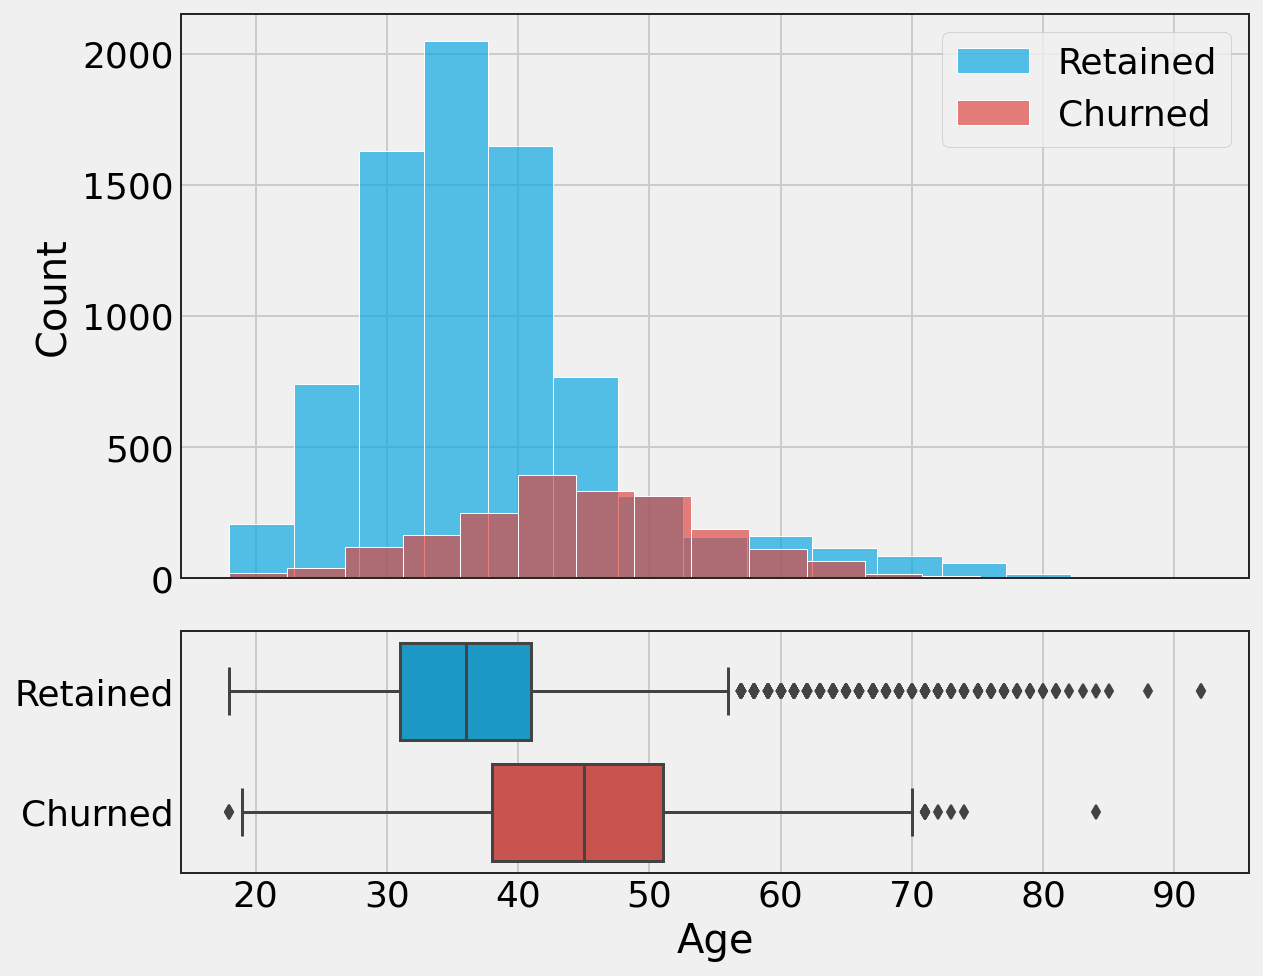

In [17]:
plot_continuous(df, 'Age')

Interestingly, there is a clear difference between age groups, with older customers more likely to churn. This observation could potentially indicate that preferences change with age, and the bank hasn't adapted its strategy to meet the requirements of older customers.

<br>

### Credit Score

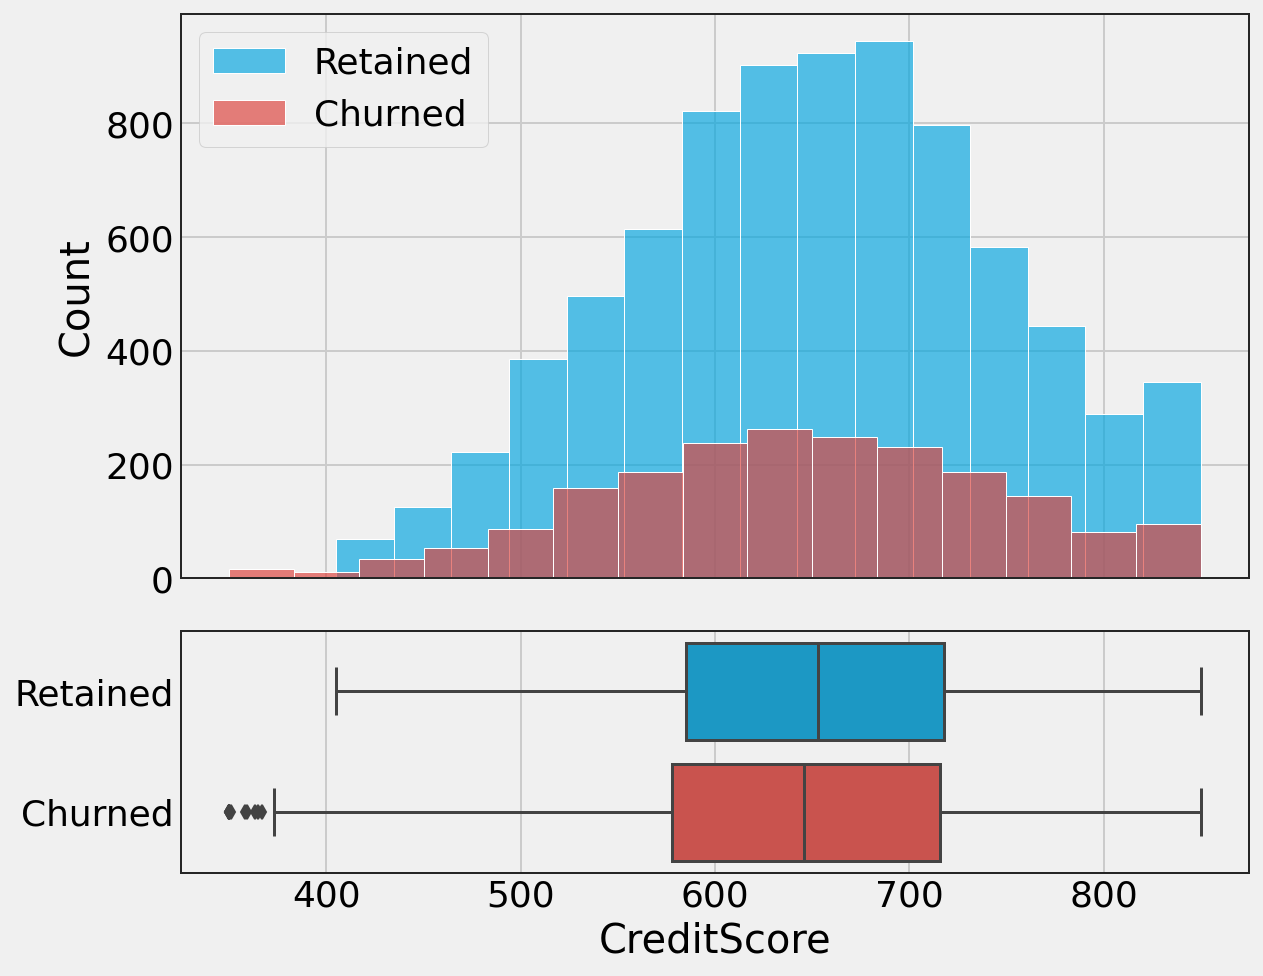

In [18]:
plot_continuous(df, 'CreditScore')

There is no significant difference between retained and churned customers in terms of their credit scores.

<br>

### Balance

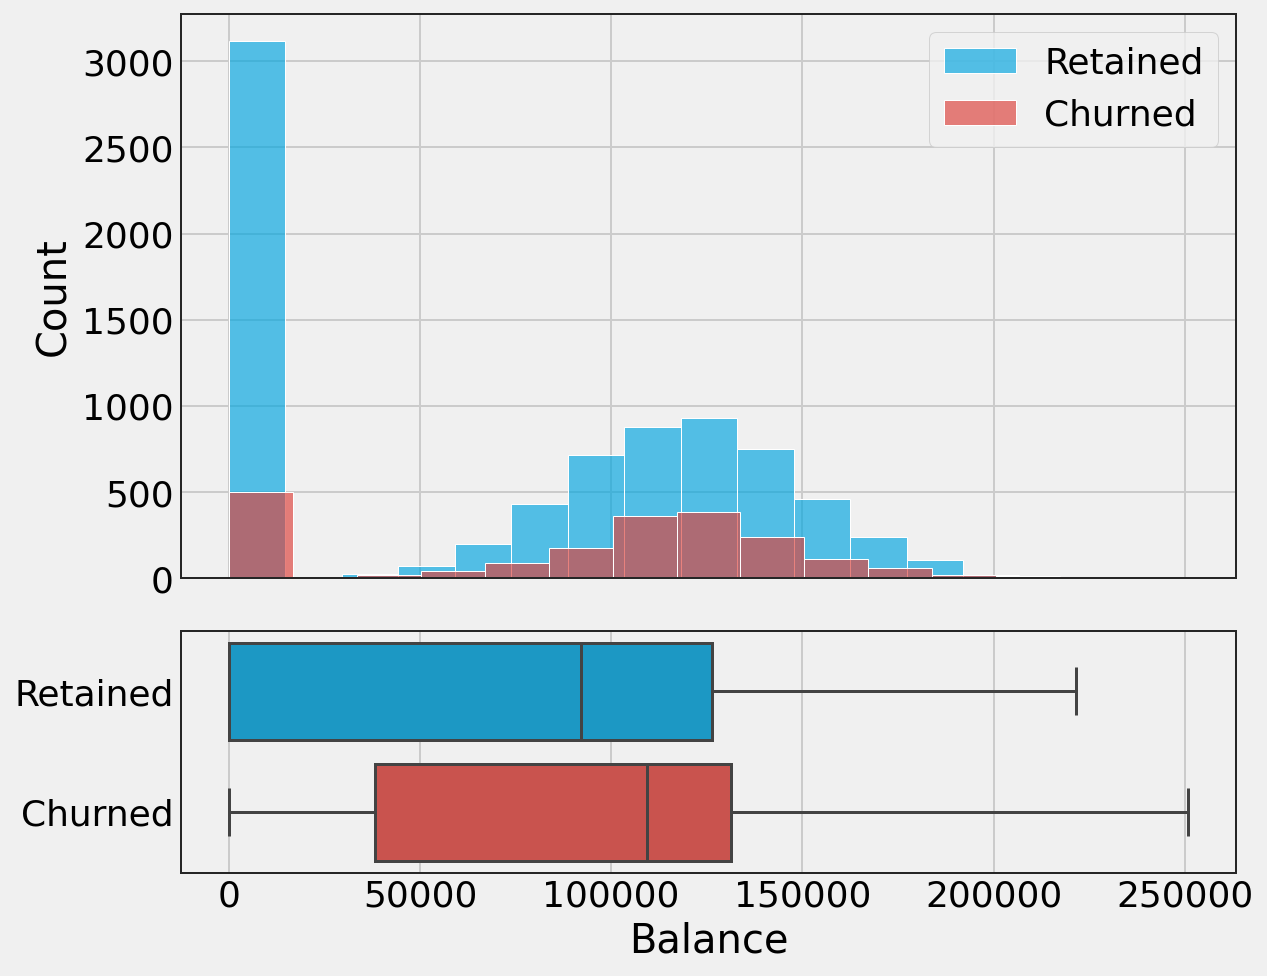

In [19]:
plot_continuous(df, 'Balance')

Again, the two distributions are pretty similar. There is a significant percentage of non-churned customers with a low account balance.

<br>

### Estimated Salary

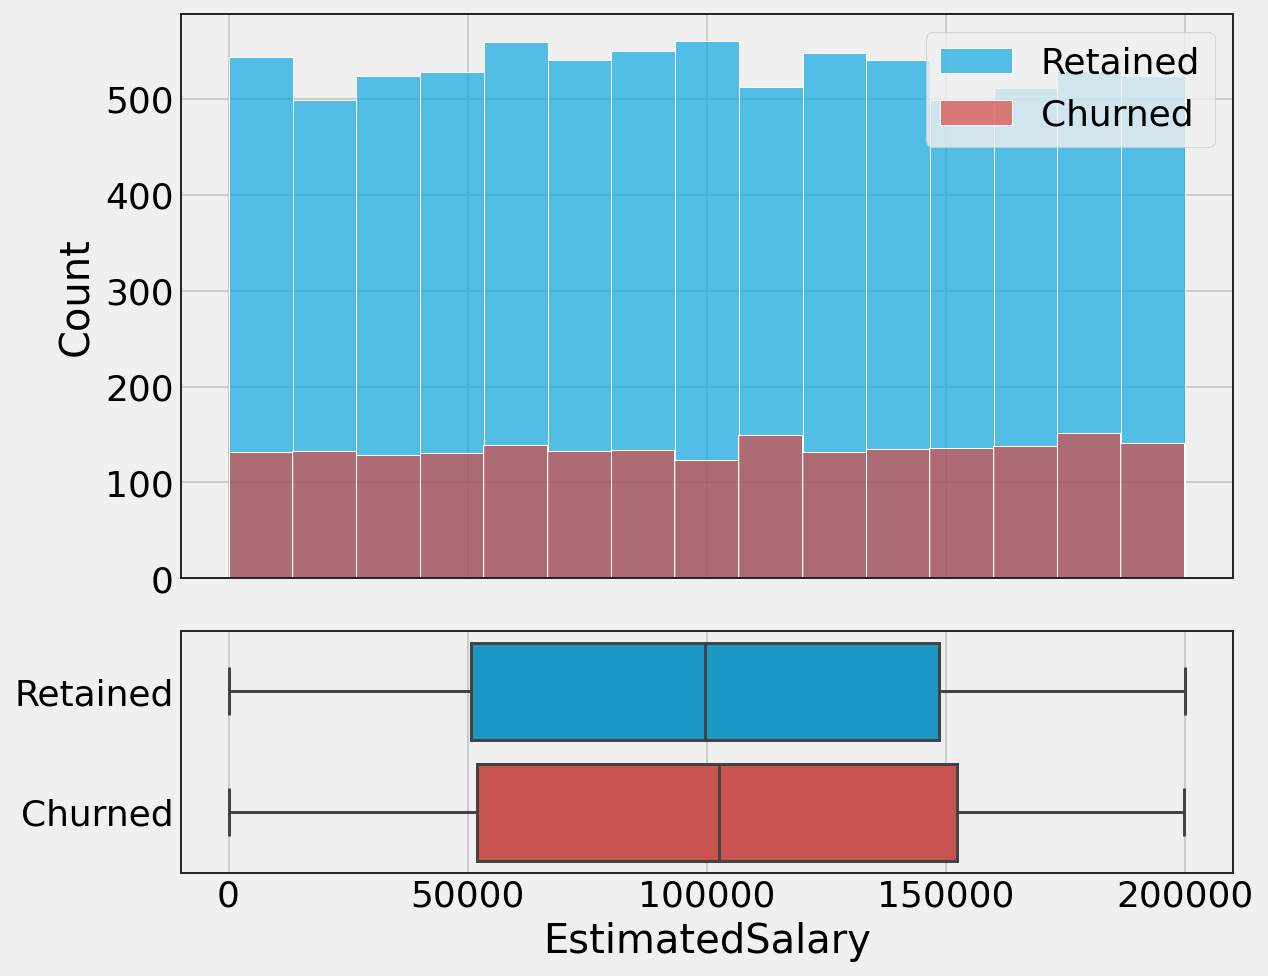

In [20]:
plot_continuous(df, 'EstimatedSalary')

ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

Both churned and retained customers display a similar uniform distribution in their salaries. Consequently, we can conclude that salary does not have a significant effect on the likelihood to churn.

<br>

## Categorical Variables

Let's plot a seaborn.countplot for each categorical feature:

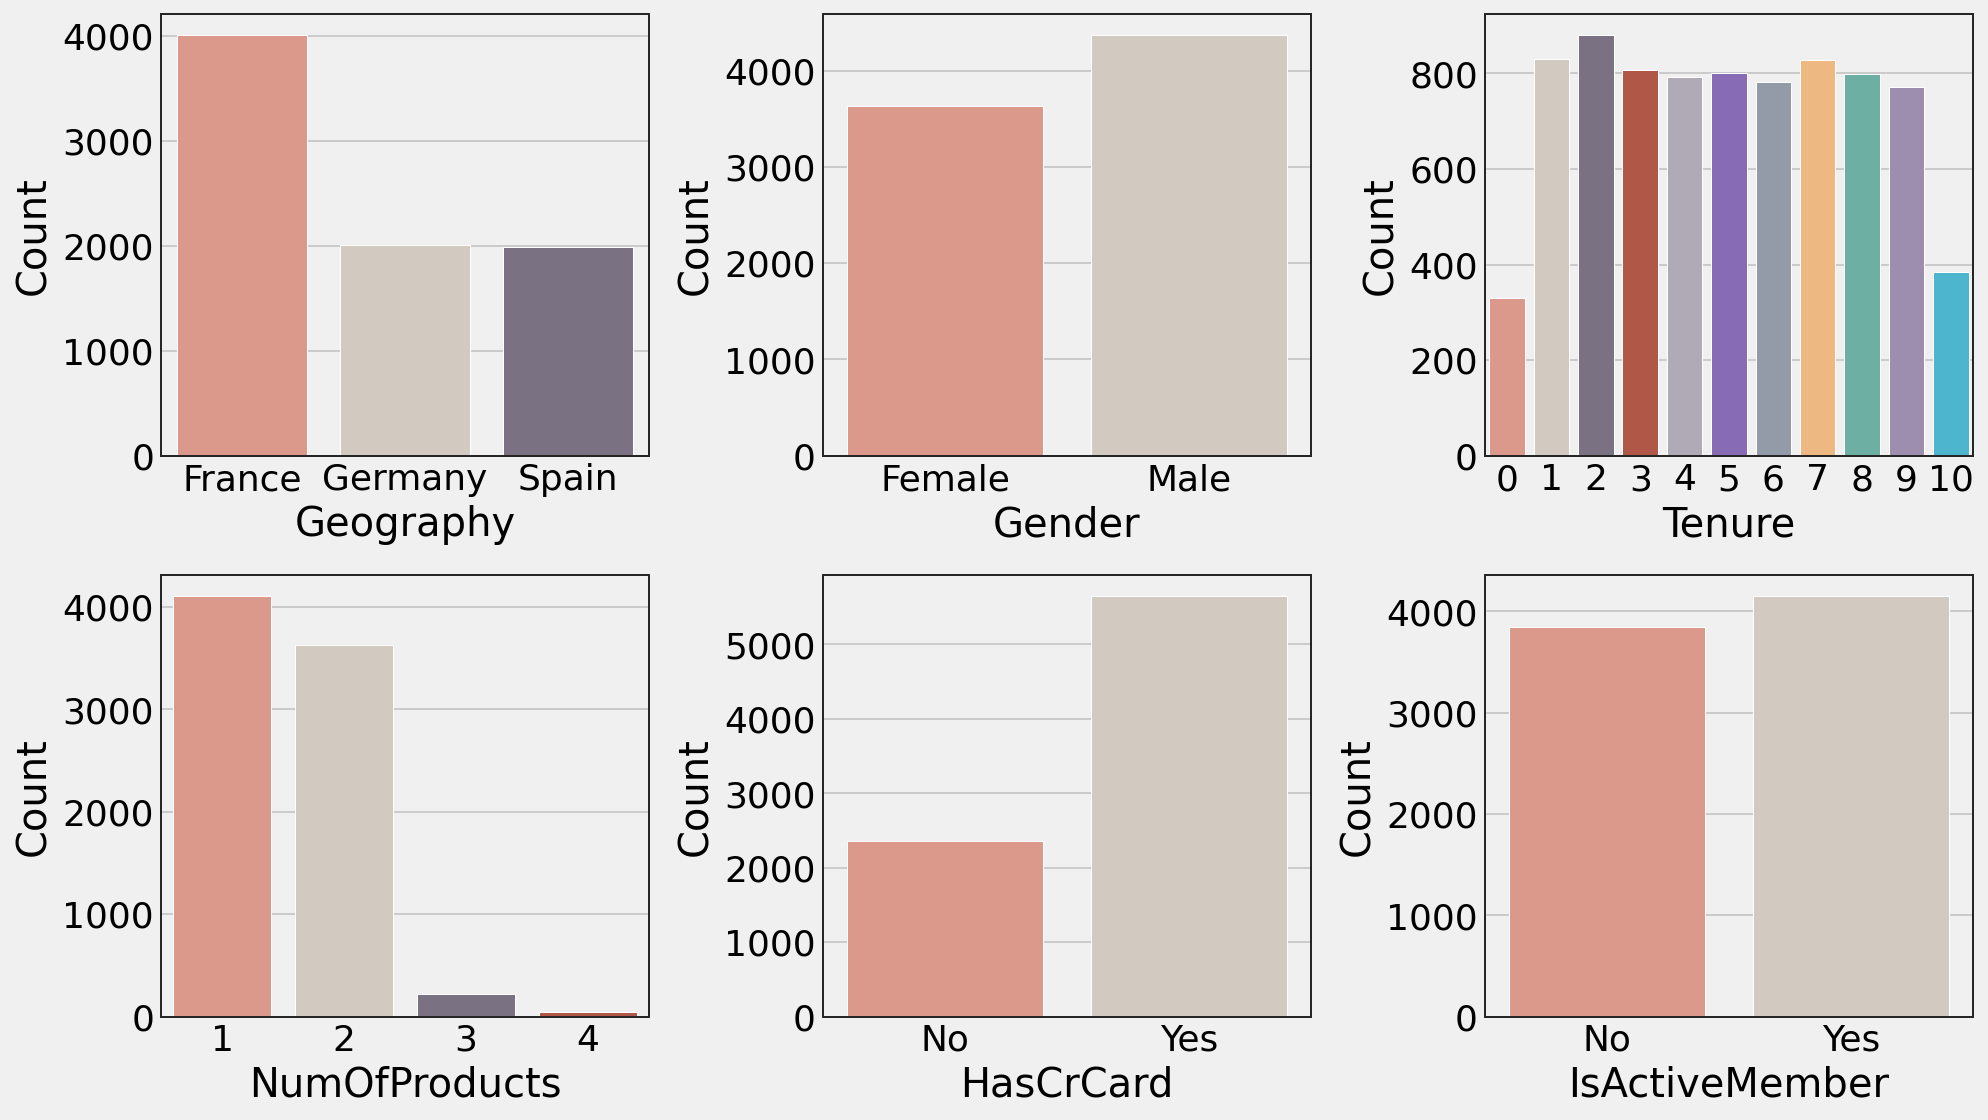

In [21]:
df_cat = train_df[categorical]

fig, ax = plt.subplots(2, 3, figsize=(14, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x=column,
                  data=train_df,
                  edgecolor=edgecolor,
                  palette=colors_cat)

    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'):
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();

Important points:

- The bank has customers in three countries (France, Spain, and Germany). Most customers are in France.
- There are more male customers than females,
- Only a small percentage leaves within the first year. The count of customers in tenure years between 1 and 9 is almost the same,
- Most of the customers have purchased 1 or 2 products, while a small portion has purchased 3 and 4,
- A significant majority of customers has a credit card, and
- Almost 50% of customers are not active.

Again, we will look at these features in greater detail.

<br>

### Geography

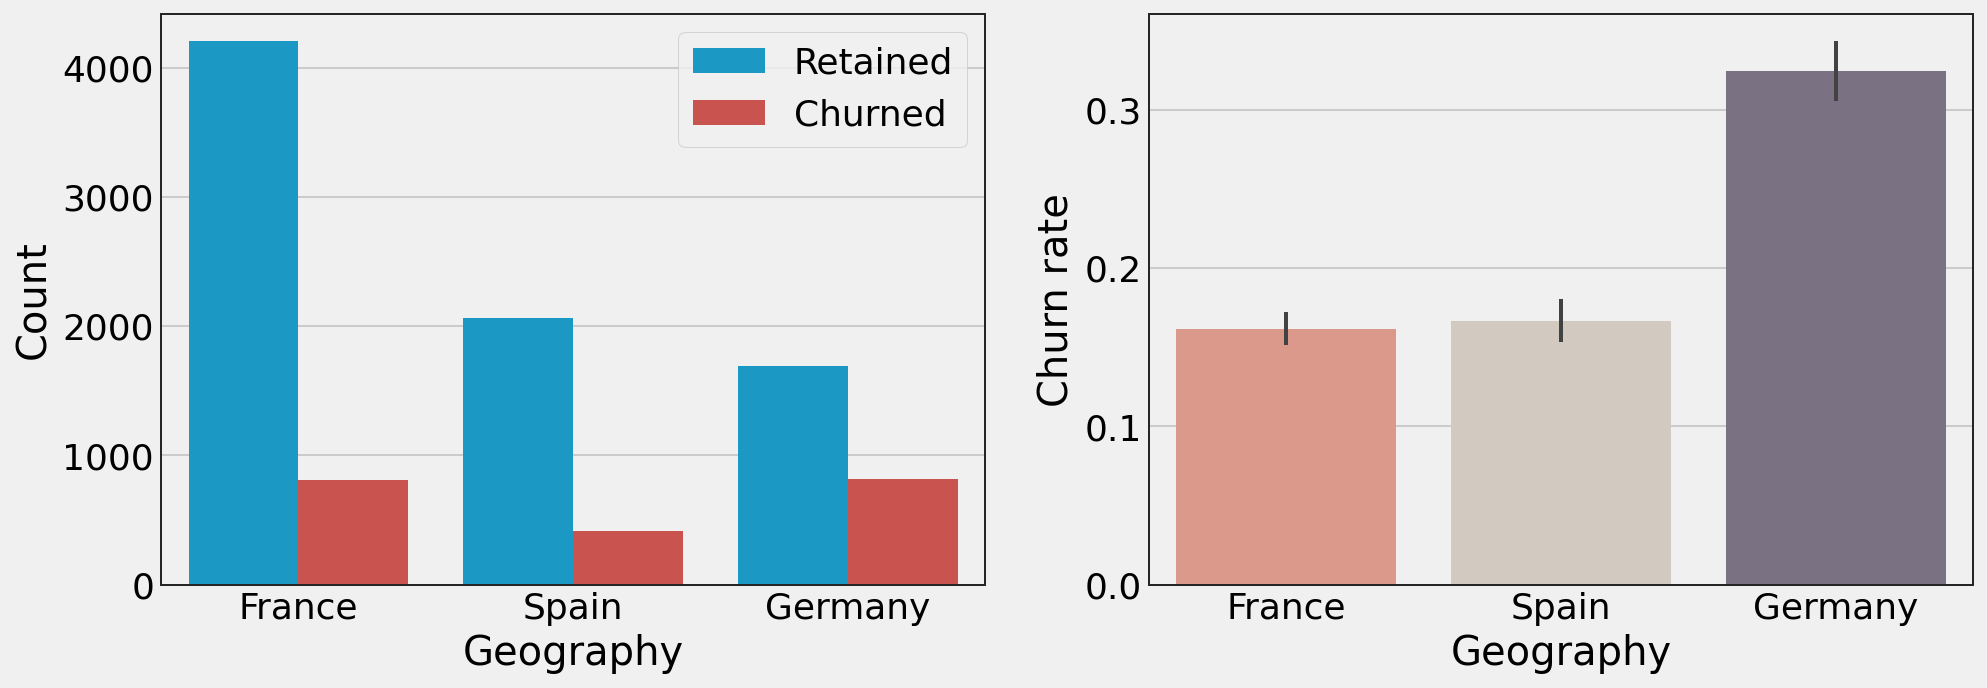

In [22]:
plot_categorical(df, 'Geography')

Customers in Germany are more likely to churn than customers in the other two countries (the churn rate is almost double compared to Spain and France). Many reasons could explain this finding, such as higher competition or different preferences for German customers.

<br>

### Gender

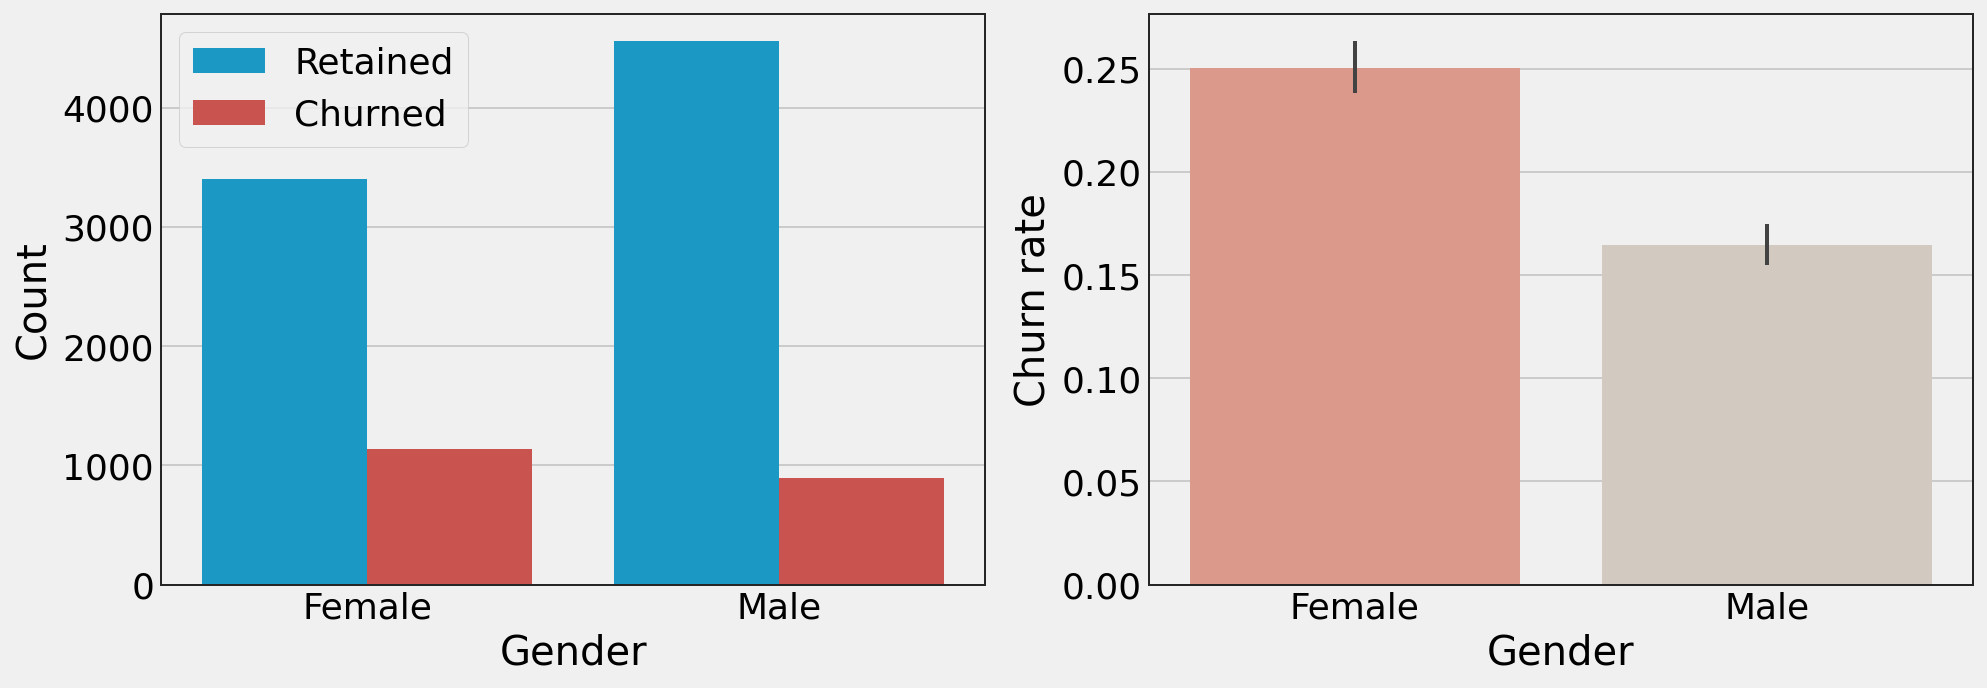

In [23]:
plot_categorical(df, 'Gender')

Female customers are more likely to churn.

<br>

### Tenure

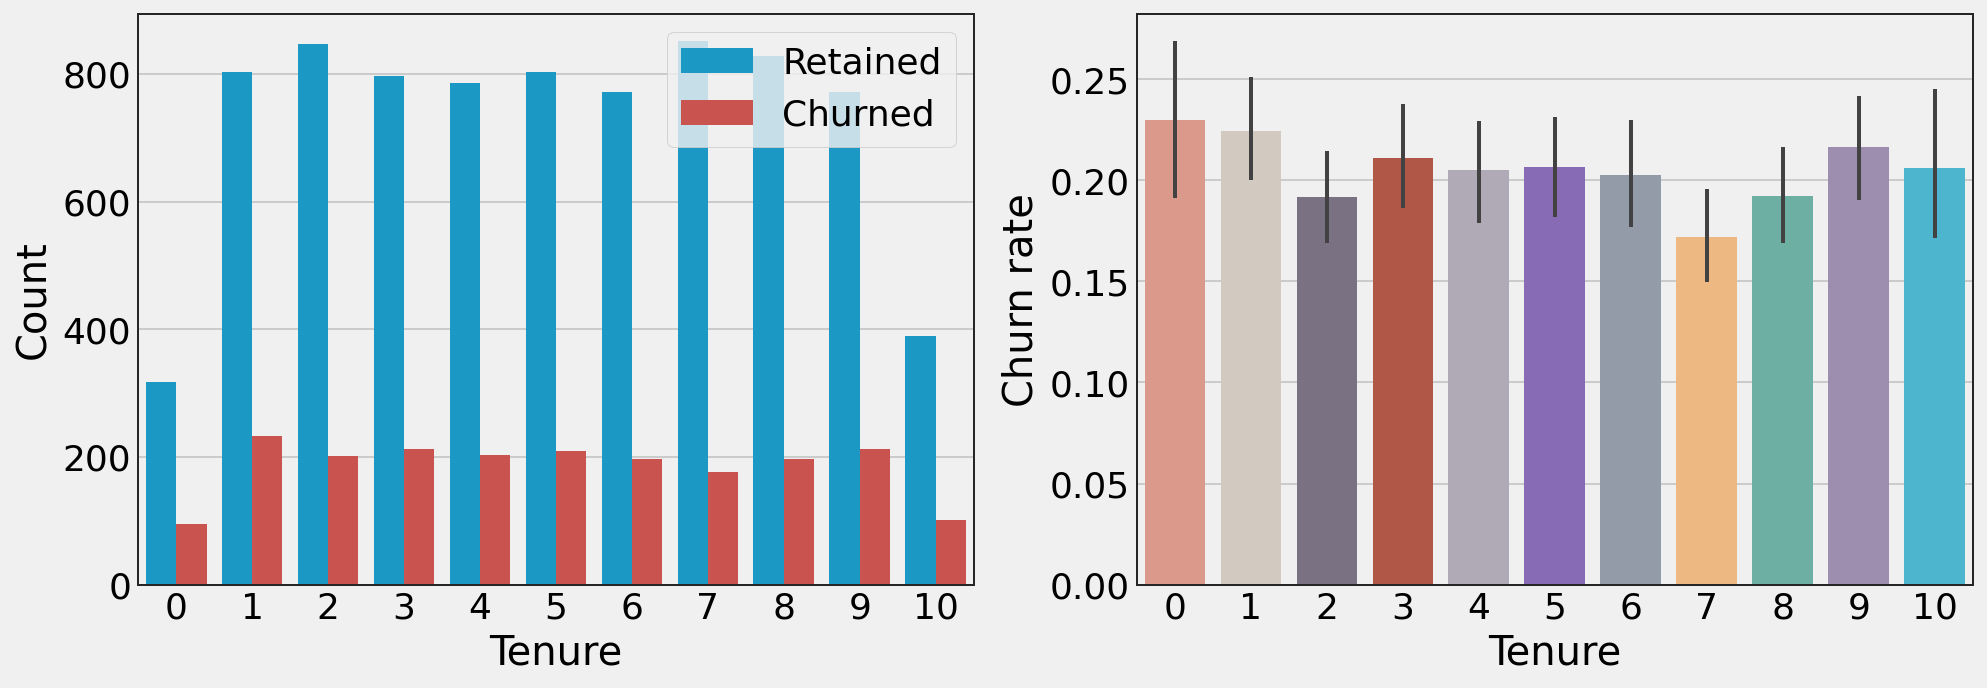

In [24]:
plot_categorical(df, 'Tenure')

The number of years (tenure) does not seem to affect the churn rate.

<br>

### Number of Products

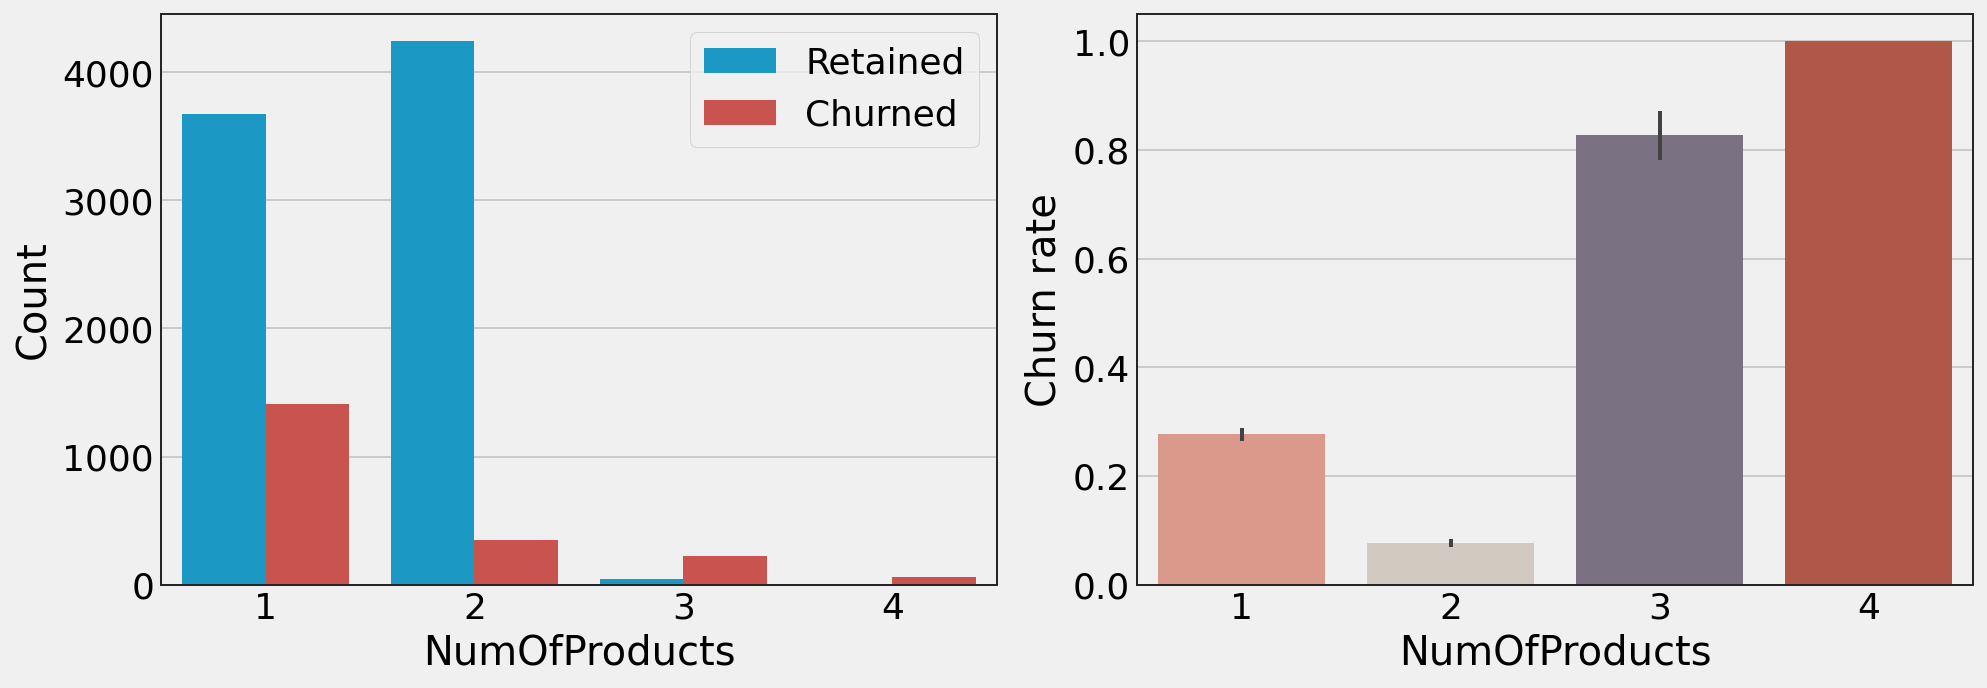

In [25]:
plot_categorical(df, 'NumOfProducts')

Interestingly, having 3 or 4 products significantly increases the likelihood of churn. I am not sure how to interpret this result. It could potentially mean that the bank cannot properly support customers with more products which in turn increases customer dissatisfaction.

<br>

### Card Holders

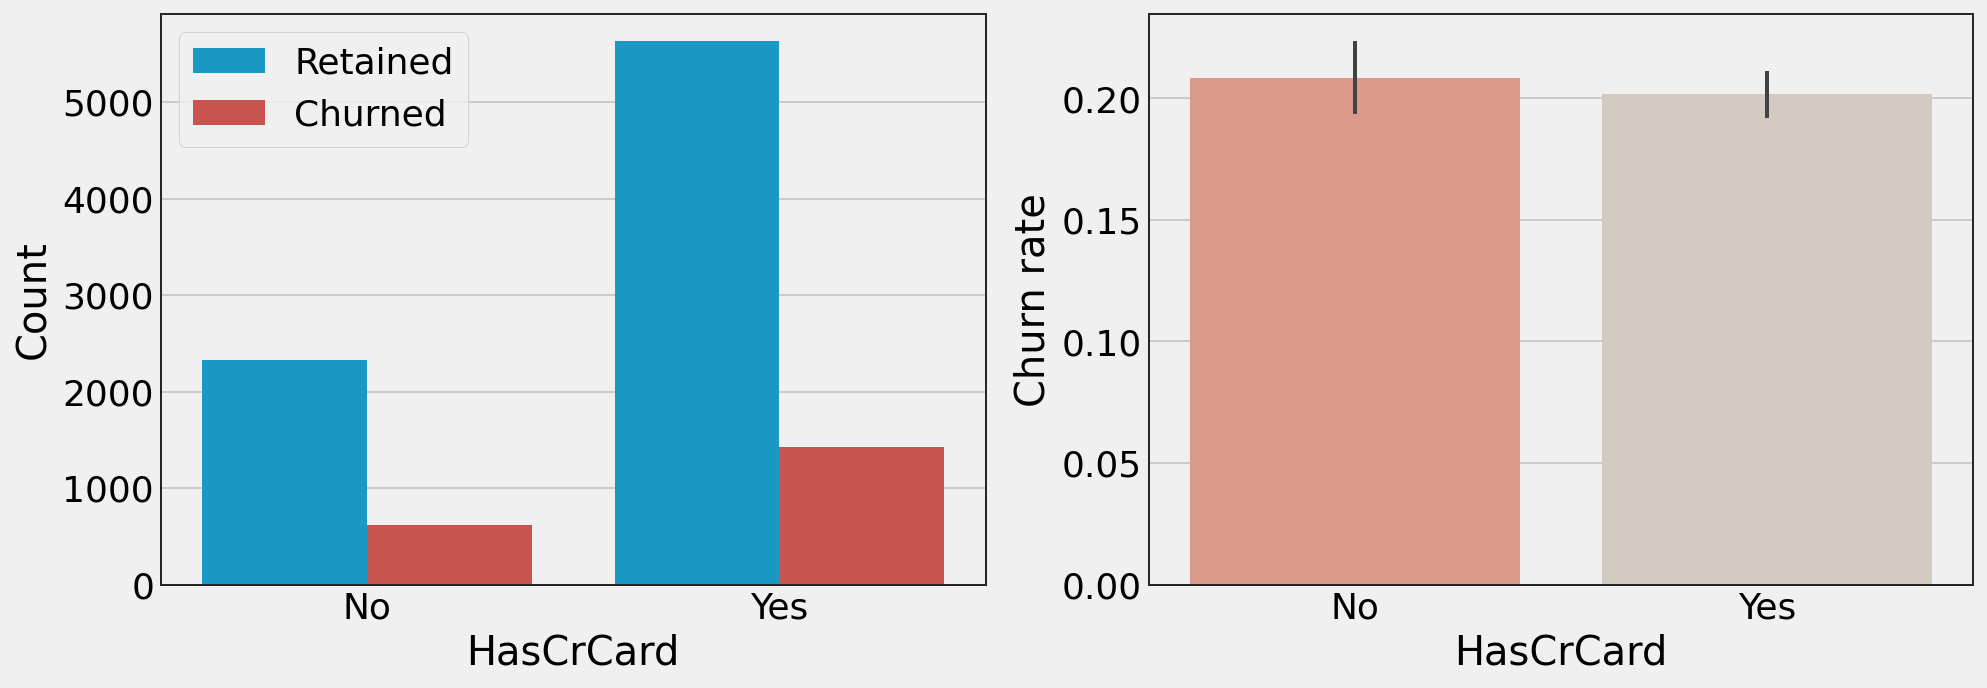

In [26]:
plot_categorical(df, 'HasCrCard')

Having a credit card does not seem to affect the churn rate.

<br>

### Active Members

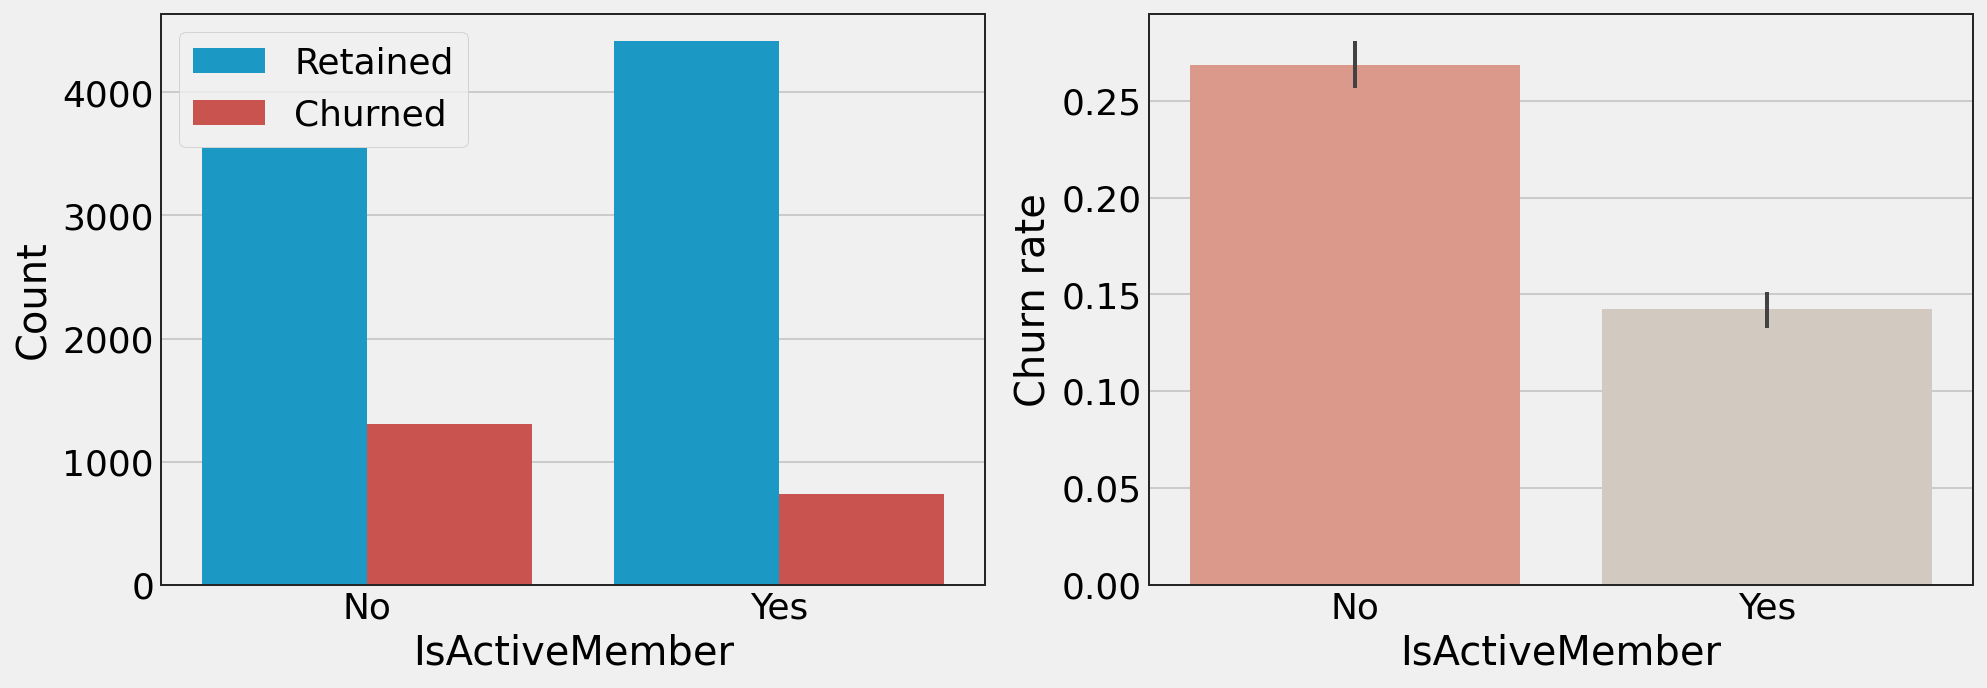

In [27]:
plot_categorical(df, 'IsActiveMember')

It is not a surprise that inactive customers are more likely to churn. A significant portion of the clientele is inactive; therefore, the bank will benefit from changing its policy so that more customers become active.

<br>

---

# Data Preprocessing

Data preprocessing is the process of converting raw data into a well-readable format that is suitable for building and training Machine Learning models.

Let's complete this process step-by-step.

<br>

## Feature Selection

We have already performed feature selection by dropping columns 'RowNumber', 'CustomerId', and 'Surname' at the beginning of our notebook. EDA revealed several more features that can be dropped as they do not provide any value in predicting our target variable:

- 'EstimatedSalary' displays a uniform distribution for both types of customers and can be dropped.
- The categories in 'Tenure' and 'HasCrCard' have a similar churn rate and are deemed redundant. This observation can be confirmed from a chi-square test [[2](#Bibliography)]:

In [28]:
chi2_array, p_array = [], []
for column in categorical:

    crosstab = pd.crosstab(train_df[column], train_df['Exited'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi2_array.append(chi2)
    p_array.append(p)

df_chi = pd.DataFrame({
    'Variable': categorical,
    'Chi-square': chi2_array,
    'p-value': p_array
})
df_chi.sort_values(by='Chi-square', ascending=False)

,Variable,Chi-square,p-value
3,NumOfProducts,1215.109,3.865e-263
0,Geography,237.940,2.148e-52
5,IsActiveMember,182.644,1.283e-41
1,Gender,95.713,1.328e-22
2,Tenure,19.438,3.504e-02
4,HasCrCard,0.560,4.544e-01


'Tenure' and 'HasCrCard' have a small chi-square and a p-value greater than 0.05 (the standard cut-off value), confirming our initial hypothesis that these two features do not convey any useful information.

We can use the `drop()` method to remove these three features from the train set:

In [29]:
features_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
train_df = train_df.drop(features_drop, axis=1)

<br>

## Encoding Categorical Features

Machine learning algorithms usually require that all input (and output) features are numeric. Consequently, categorical features need to be converted (encoded) to numbers before building models.

Our dataset contains two features that require encoding.

- For 'Gender', we will use scikit-learn's `LabelEncoder()` which maps each unique label to an integer (Male --> 1 and Female --> 0).
- For 'Geography', we will manually map values so that customers in Germany have the value of one (1) and all other customers (France and Spain) have zero (0). I chose this method since the churn rate for customers in the other two countries is almost equal and considerably lower than in Germany. Therefore, it makes sense to encode this feature so that it differentiates between German and non-German customers. Additionally, I tried one-hot encoding (`get_dummies()`) this feature, and the two new features for France and Spain had small feature importance.


In [30]:
train_df['Gender'] = LabelEncoder().fit_transform(train_df['Gender'])

train_df['Geography'] = train_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

<br>

## Scaling

Feature scaling is a technique used to normalise the range of features in a dataset. Some algorithms are sensitive to feature scaling (e.g. SVMs), while others are invariant (e.g. Random Forests).

I decided to use StandardScaler(), which standardises features by subtracting the mean and dividing by the standard deviation. This transformation results in features with zero mean and unit variance.

In [31]:
scaler = StandardScaler()

scl_columns = ['CreditScore', 'Age', 'Balance']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])

Finally, we will split the train set into 'X_train' and 'y_train' sets:

In [32]:
y_train = train_df['Exited']
X_train = train_df.drop('Exited', 1)

<br>

## Addressing Class Imbalance

As we have seen previously, there is an imbalance in the classes to be predicted, with one class (0 – retained) much more prevalent than the other (1 - churned):

In [33]:
y_train.value_counts()

0    6370
1    1630
Name: Exited, dtype: int64

Class imbalance is usually a problem and occurs in many real-world tasks. Classification using imbalanced data favours 
the majority class, meaning that machine learning algorithms will likely result in models that do little more than predict the most common class. Also, common metrics can be misleading when handling class-imbalanced data (e.g. if a dataset contains 99.9% 0s and 0.1% 1s, a classifier that always predicts 0 will have 99.9% accuracy).

Thankfully, some methods can address this problem. **Resampling** is a widely adopted technique designed to alter the class distribution in the training dataset. It consists of removing instances of the majority class (**Undersampling**) and/or adding copies of instances from the minority class (**Oversampling**). Additionally, there are algorithms for generating **synthetic** instances of the minory class. For instance, as we read in [[2](#Bibliography)], the **SMOTE** ('Synthetic Minority Oversampling Technique') algorithm '*finds a record that is similar to the record being upsampled and creates a synthetic record that is a randomly weighted average of the original record and the neighbouring record, where the weight is generated separately for each predictor*'.

In this project, we will leave our dataset untouched and use the same algorithms but give them a different perspective on the problem. **Penalised classification** imposes an additional cost on the model for making classification mistakes on the minority class during training. These penalties can bias the model to pay more attention to the minority class [3](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/).

<br>


<br>

---

# Building Machine Learning Models

## Baseline Models

This section aims to calculate the **baseline performance** of our classifiers. Apart from the `random_state` and `class_weigth` arguments, we will use the default parameters for each classifier. 

In [38]:
ratio = y_train.value_counts()[0]/y_train.value_counts()[1] # Ratio of number of negative class to the positive class - Needed for XGB classifier

clf_list = [('GNB', GaussianNB()),
            ('LR', LogisticRegression(random_state=random_state,
                                      class_weight='balanced')),
            ('SVC', SVC(probability=True,
                        random_state=random_state,
                        class_weight='balanced')),
            ('RF', RandomForestClassifier(random_state=random_state,
                                          class_weight='balanced')),
            ('BRF', BalancedRandomForestClassifier(random_state=random_state,
                                                   class_weight='balanced')),
            ('GBC', GradientBoostingClassifier(random_state=random_state)),
            ('XGB', XGBClassifier(random_state=random_state,
                                  scale_pos_weight=ratio)),
            ('LGBMC', LGBMClassifier(random_state=random_state,
                                     is_unbalance=True,
                                     class_weight='balanced'))]

Their performance will be evaluated based on five metrics and by performing **k-fold cross-validation**. The idea behind k-fold cross-validation, which is illustrated in [this figure](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png), is simple: it splits the (training) set into k subsets/folds, trains the models using k-1 folds, and evaluates the model on the remaining one fold. This process is repeated until every fold is tested once.

In [39]:
scoring_metrics = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1']
cv = KFold(n_splits=5, random_state=random_state, shuffle=True)

In [62]:
baseline = {}
for scoring_metric in scoring_metrics:
    scoring_data = []

    for clf in clf_list:
        cv_scores = cross_val_score(estimator=clf[1],
                                    X=X_train,
                                    y=y_train,
                                    scoring=scoring_metric,
                                    cv=cv,
                                    n_jobs=-1)

        scoring_data.append(cv_scores.mean())

    baseline[scoring_metric] = scoring_data

baseline_df = pd.DataFrame(
    data=baseline,
    index=[clf_list[i][0] for i in range(len(clf_list))])

baseline_df.columns = ['Accuracy', 'AUC', 'Precision', 'Recall', 'F1']

baseline_df.style.highlight_max(color='indianred', axis=0)

,Accuracy,AUC,Precision,Recall,F1
GNB,0.824,0.796,0.635,0.326,0.430
LR,0.715,0.770,0.389,0.695,0.499
SVC,0.795,0.857,0.499,0.744,0.597
RF,0.852,0.837,0.704,0.476,0.568
BRF,0.787,0.846,0.485,0.741,0.587
GBC,0.866,0.865,0.781,0.479,0.593
XGB,0.820,0.837,0.549,0.641,0.591
LGBMC,0.696,0.853,0.386,0.835,0.528


<br>

## Model Tuning

<br>

# Results

<br>

---

# Evaluating the Test Set

<br>

---


# Bibliography

<br>

# Conclusions